In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import statistics

from rdkit import Chem
from rdkit import DataStructs
from rdkit import rdBase
from rdkit import RDConfig
from rdkit.Chem import ChemicalFeatures
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdMolDescriptors as rdescriptors
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprint
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker
from rdkit.Chem.Pharm2D import Gobbi_Pharm2D,Generate

from sklearn import model_selection
from sklearn import linear_model
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
from sklearn.preprocessing import LabelEncoder,label_binarize
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.metrics import precision_recall_curve

RDKit WARNING: [03:00:46] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
def PR_curve(y,pred):
    pos = np.sum(y == 1)
    neg = np.sum(y == 0)
    pred_sort = np.sort(pred)[::-1] 
    index = np.argsort(pred)[::-1]  
    y_sort = y[index]
    print(y_sort)

    Pre = []
    Rec = []
    for i, item in enumerate(pred_sort):
        if i == 0:
            Pre.append(1)
            Rec.append(0)


        else:
            Pre.append(np.sum((y_sort[:i] == 1)) /i)
            Rec.append(np.sum((y_sort[:i] == 1)) / pos)
    print(Pre)
    print(Rec)

    plt.plot(Rec, Pre, 'k',color='skyblue')
    plt.legend(loc='lower right')

    plt.title('Receiver Operating Characteristic')
    #plt.plot([(0, 0), (1, 1)], 'r--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 01.01])
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.show()

In [3]:
Test_Size = 0.3
times = 20
f_bit = 1024
Mean_acc= []

In [4]:
#df = pd.read_csv('/home/is/zi-yang/Cov/Balanced-SARS-CoV-2_pAC50.csv', index_col=0)
df = pd.read_csv('/home/is/mostatika-a/PBL new/Balanced-SARS-CoV-2_cytopathic_effect_(CPE)-clean.csv', index_col=0)
df['molecules'] = df.SMILES.apply(Chem.MolFromSmiles)
df = df.drop(columns=['SMILES', 'mean_pAC50'])
df

,Class,molecules
SAMPLE_ID,,
NCGC00343768-05,1,<rdkit.Chem.rdchem.Mol object at 0x7fad87477ca0>
NCGC00386831-01,1,<rdkit.Chem.rdchem.Mol object at 0x7fad8747d0a0>
NCGC00263232-01,1,<rdkit.Chem.rdchem.Mol object at 0x7fad8747d160>
NCGC00246387-06&NCGC00246387-08,1,<rdkit.Chem.rdchem.Mol object at 0x7fad8747d1c0>
NCGC00263100-02,1,<rdkit.Chem.rdchem.Mol object at 0x7fad8747d220>
...,...,...
NCGC00378821-01,0,<rdkit.Chem.rdchem.Mol object at 0x7fad8742d700>
NCGC00182980-01,0,<rdkit.Chem.rdchem.Mol object at 0x7fad8742d760>
NCGC00480888-01,0,<rdkit.Chem.rdchem.Mol object at 0x7fad8742d7c0>


In [5]:
df['ECFP4']=df.molecules.apply(lambda m: AllChem.GetMorganFingerprintAsBitVect(m, radius=2, nBits = f_bit))
df['ECFP6']=df.molecules.apply(lambda m: AllChem.GetMorganFingerprintAsBitVect(m, radius=3, nBits = f_bit))
df['ECFP8']=df.molecules.apply(lambda m: AllChem.GetMorganFingerprintAsBitVect(m, radius=4, nBits = f_bit))
df['ECFP10']=df.molecules.apply(lambda m: AllChem.GetMorganFingerprintAsBitVect(m, radius=5, nBits = f_bit))
df['ECFP12']=df.molecules.apply(lambda m: AllChem.GetMorganFingerprintAsBitVect(m, radius=6, nBits = f_bit))
df['RDKFP']=df.molecules.apply(lambda m: AllChem.RDKFingerprint(m, fpSize=512))
df

,Class,molecules,ECFP4,ECFP6,ECFP8,ECFP10,ECFP12,RDKFP
SAMPLE_ID,,,,,,,,
NCGC00343768-05,1,<rdkit.Chem.rdchem.Mol object at 0x7fad87477ca0>,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, ..."
NCGC00386831-01,1,<rdkit.Chem.rdchem.Mol object at 0x7fad8747d0a0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, ..."
NCGC00263232-01,1,<rdkit.Chem.rdchem.Mol object at 0x7fad8747d160>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
NCGC00246387-06&NCGC00246387-08,1,<rdkit.Chem.rdchem.Mol object at 0x7fad8747d1c0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
NCGC00263100-02,1,<rdkit.Chem.rdchem.Mol object at 0x7fad8747d220>,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
...,...,...,...,...,...,...,...,...
NCGC00378821-01,0,<rdkit.Chem.rdchem.Mol object at 0x7fad8742d700>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
NCGC00182980-01,0,<rdkit.Chem.rdchem.Mol object at 0x7fad8742d760>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ..."
NCGC00480888-01,0,<rdkit.Chem.rdchem.Mol object at 0x7fad8742d7c0>,"[0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [6]:
f_names = [x[0] for x in Descriptors._descList]
s = 'Descriptors.'
for i in range(len(f_names)):
    f_names[i] = s + f_names[i]
print('#used features:',len(f_names))

for i in f_names:
    df[i] = df.molecules.apply(lambda m: eval(i)(m))
df = df.dropna()
df

#used features: 200


,Class,molecules,ECFP4,ECFP6,ECFP8,ECFP10,ECFP12,RDKFP,Descriptors.MaxEStateIndex,Descriptors.MinEStateIndex,...,Descriptors.fr_sulfide,Descriptors.fr_sulfonamd,Descriptors.fr_sulfone,Descriptors.fr_term_acetylene,Descriptors.fr_tetrazole,Descriptors.fr_thiazole,Descriptors.fr_thiocyan,Descriptors.fr_thiophene,Descriptors.fr_unbrch_alkane,Descriptors.fr_urea
SAMPLE_ID,,,,,,,,,,,,,,,,,,,,,
NCGC00343768-05,1,<rdkit.Chem.rdchem.Mol object at 0x7fad87477ca0>,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, ...",12.325617,-0.426538,...,0,0,0,0,0,0,0,0,0,1
NCGC00386831-01,1,<rdkit.Chem.rdchem.Mol object at 0x7fad8747d0a0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, ...",12.387263,-1.147456,...,0,0,0,0,0,0,0,0,0,0
NCGC00263232-01,1,<rdkit.Chem.rdchem.Mol object at 0x7fad8747d160>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",13.516034,-0.139098,...,0,0,0,0,0,0,0,0,0,0
NCGC00246387-06&NCGC00246387-08,1,<rdkit.Chem.rdchem.Mol object at 0x7fad8747d1c0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",12.986619,-0.357879,...,1,0,0,0,0,0,0,0,0,0
NCGC00263100-02,1,<rdkit.Chem.rdchem.Mol object at 0x7fad8747d220>,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",13.983988,-0.882951,...,0,0,0,0,0,0,0,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NCGC00378821-01,0,<rdkit.Chem.rdchem.Mol object at 0x7fad8742d700>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",13.398813,-0.178876,...,0,0,0,1,0,0,0,0,0,0
NCGC00182980-01,0,<rdkit.Chem.rdchem.Mol object at 0x7fad8742d760>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ...",12.507249,-0.197997,...,0,0,0,0,0,0,0,0,0,0
NCGC00480888-01,0,<rdkit.Chem.rdchem.Mol object at 0x7fad8742d7c0>,"[0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",14.250337,-0.474609,...,1,0,0,0,0,0,0,0,0,0


In [7]:
[x[0] for x in Descriptors._descList]

['MaxEStateIndex',
 'MinEStateIndex',
 'MaxAbsEStateIndex',
 'MinAbsEStateIndex',
 'qed',
 'MolWt',
 'HeavyAtomMolWt',
 'ExactMolWt',
 'NumValenceElectrons',
 'NumRadicalElectrons',
 'MaxPartialCharge',
 'MinPartialCharge',
 'MaxAbsPartialCharge',
 'MinAbsPartialCharge',
 'FpDensityMorgan1',
 'FpDensityMorgan2',
 'FpDensityMorgan3',
 'BalabanJ',
 'BertzCT',
 'Chi0',
 'Chi0n',
 'Chi0v',
 'Chi1',
 'Chi1n',
 'Chi1v',
 'Chi2n',
 'Chi2v',
 'Chi3n',
 'Chi3v',
 'Chi4n',
 'Chi4v',
 'HallKierAlpha',
 'Ipc',
 'Kappa1',
 'Kappa2',
 'Kappa3',
 'LabuteASA',
 'PEOE_VSA1',
 'PEOE_VSA10',
 'PEOE_VSA11',
 'PEOE_VSA12',
 'PEOE_VSA13',
 'PEOE_VSA14',
 'PEOE_VSA2',
 'PEOE_VSA3',
 'PEOE_VSA4',
 'PEOE_VSA5',
 'PEOE_VSA6',
 'PEOE_VSA7',
 'PEOE_VSA8',
 'PEOE_VSA9',
 'SMR_VSA1',
 'SMR_VSA10',
 'SMR_VSA2',
 'SMR_VSA3',
 'SMR_VSA4',
 'SMR_VSA5',
 'SMR_VSA6',
 'SMR_VSA7',
 'SMR_VSA8',
 'SMR_VSA9',
 'SlogP_VSA1',
 'SlogP_VSA10',
 'SlogP_VSA11',
 'SlogP_VSA12',
 'SlogP_VSA2',
 'SlogP_VSA3',
 'SlogP_VSA4',
 'SlogP_V

In [8]:
Active = df['Class'].values

ECFP4 = np.array(list(df['ECFP4']))
ECFP6 = np.array(list(df['ECFP6']))
ECFP8 = np.array(list(df['ECFP8']))
ECFP10 = np.array(list(df['ECFP10']))
ECFP12 = np.array(list(df['ECFP12']))
RDKFP = np.array(list(df['RDKFP']))

ECFP4_6 = np.concatenate((ECFP4, ECFP6), axis=1)
ECFP4_8 = np.concatenate((ECFP4, ECFP6, ECFP8), axis=1)
ECFP4_10 = np.concatenate((ECFP4, ECFP6, ECFP8, ECFP10), axis=1)
ECFP4_12 = np.concatenate((ECFP4, ECFP6, ECFP8, ECFP10, ECFP12), axis=1)
ECFP4_12_RDKFP = np.concatenate((ECFP4, ECFP6, ECFP8, ECFP10, ECFP12, RDKFP), axis=1)

features = np.array(df.iloc[:,8:])
ECFP4_6_f = np.concatenate((ECFP4, ECFP6, features), axis=1)

Mean_Train_accuracy_score: 1.0
Mean_Test_accuracy_score: 0.8537216828478964
              precision    recall  f1-score   support

           0       0.83      0.81      0.82       163
           1       0.79      0.82      0.80       146

    accuracy                           0.81       309
   macro avg       0.81      0.81      0.81       309
weighted avg       0.81      0.81      0.81       309



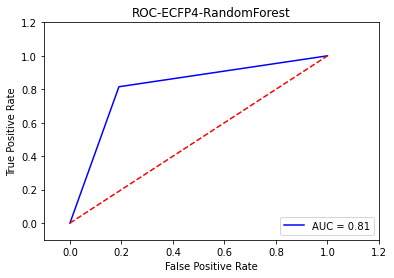

In [9]:
#Test-ECFP4
Train_accuracy_score = []
Test_accuracy_score = []

for i in range(times):
    X_train, X_test, y_train, y_test = model_selection.train_test_split(ECFP4, Active, test_size= Test_Size)

    rf = RandomForestClassifier(max_features='auto')
    rf.fit(X_train, y_train)

    rf_lab = rf.predict(X_train)
    rf_pre = rf.predict(X_test)
    
    Train_accuracy_score.append(accuracy_score(y_train,rf_lab))
    Test_accuracy_score.append(accuracy_score(y_test,rf_pre))

Mean_acc.append(statistics.mean(Test_accuracy_score))
print("Mean_Train_accuracy_score:",statistics.mean(Train_accuracy_score))
print("Mean_Test_accuracy_score:",statistics.mean(Test_accuracy_score))
print(classification_report(y_test, rf_pre, target_names=np.arange(2).astype(str)))

y_pred = rf.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.title('ROC-ECFP4-RandomForest')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.savefig("ROC.jpg", dpi = 300)
plt.show()

Mean_Train_accuracy_score: 1.0
Mean_Test_accuracy_score: 0.8394822006472492
              precision    recall  f1-score   support

           0       0.82      0.85      0.84       148
           1       0.86      0.83      0.85       161

    accuracy                           0.84       309
   macro avg       0.84      0.84      0.84       309
weighted avg       0.84      0.84      0.84       309



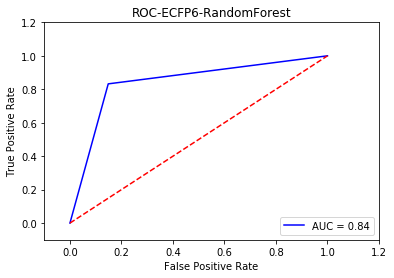

In [71]:
#Test-ECFP6
Train_accuracy_score = []
Test_accuracy_score = []

for i in range(times):
    X_train, X_test, y_train, y_test = model_selection.train_test_split(ECFP6, Active, test_size= Test_Size)

    rf = RandomForestClassifier(max_features='auto')
    rf.fit(X_train, y_train)

    rf_lab = rf.predict(X_train)
    rf_pre = rf.predict(X_test)
    
    Train_accuracy_score.append(accuracy_score(y_train,rf_lab))
    Test_accuracy_score.append(accuracy_score(y_test,rf_pre))

Mean_acc.append(statistics.mean(Test_accuracy_score))
print("Mean_Train_accuracy_score:",statistics.mean(Train_accuracy_score))
print("Mean_Test_accuracy_score:",statistics.mean(Test_accuracy_score))
print(classification_report(y_test, rf_pre, target_names=np.arange(2).astype(str)))

y_pred = rf.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.title('ROC-ECFP6-RandomForest')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.savefig("ROC.jpg", dpi = 300)
plt.show()

Mean_Train_accuracy_score: 1.0
Mean_Test_accuracy_score: 0.8174757281553399
              precision    recall  f1-score   support

           0       0.81      0.79      0.80       148
           1       0.81      0.83      0.82       161

    accuracy                           0.81       309
   macro avg       0.81      0.81      0.81       309
weighted avg       0.81      0.81      0.81       309



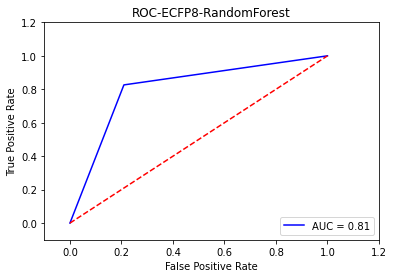

In [10]:
#Test-ECFP8
Train_accuracy_score = []
Test_accuracy_score = []

for i in range(times):
    X_train, X_test, y_train, y_test = model_selection.train_test_split(ECFP8, Active, test_size= Test_Size)

    rf = RandomForestClassifier(max_features='auto')
    rf.fit(X_train, y_train)

    rf_lab = rf.predict(X_train)
    rf_pre = rf.predict(X_test)
    
    Train_accuracy_score.append(accuracy_score(y_train,rf_lab))
    Test_accuracy_score.append(accuracy_score(y_test,rf_pre))

Mean_acc.append(statistics.mean(Test_accuracy_score))
print("Mean_Train_accuracy_score:",statistics.mean(Train_accuracy_score))
print("Mean_Test_accuracy_score:",statistics.mean(Test_accuracy_score))
print(classification_report(y_test, rf_pre, target_names=np.arange(2).astype(str)))

y_pred = rf.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.title('ROC-ECFP8-RandomForest')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.savefig("ROC.jpg", dpi = 300)
plt.show()

Mean_Train_accuracy_score: 1.0
Mean_Test_accuracy_score: 0.8106796116504854
              precision    recall  f1-score   support

           0       0.79      0.82      0.81       152
           1       0.82      0.79      0.81       157

    accuracy                           0.81       309
   macro avg       0.81      0.81      0.81       309
weighted avg       0.81      0.81      0.81       309



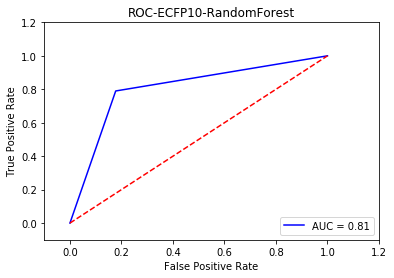

In [73]:
#Test-ECFP10
Train_accuracy_score = []
Test_accuracy_score = []

for i in range(times):
    X_train, X_test, y_train, y_test = model_selection.train_test_split(ECFP10, Active, test_size= Test_Size)

    rf = RandomForestClassifier(max_features='auto')
    rf.fit(X_train, y_train)

    rf_lab = rf.predict(X_train)
    rf_pre = rf.predict(X_test)
    
    Train_accuracy_score.append(accuracy_score(y_train,rf_lab))
    Test_accuracy_score.append(accuracy_score(y_test,rf_pre))

Mean_acc.append(statistics.mean(Test_accuracy_score))
print("Mean_Train_accuracy_score:",statistics.mean(Train_accuracy_score))
print("Mean_Test_accuracy_score:",statistics.mean(Test_accuracy_score))
print(classification_report(y_test, rf_pre, target_names=np.arange(2).astype(str)))

y_pred = rf.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.title('ROC-ECFP10-RandomForest')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.savefig("ROC.jpg", dpi = 300)
plt.show()

Mean_Train_accuracy_score: 1.0
Mean_Test_accuracy_score: 0.7983818770226537
              precision    recall  f1-score   support

           0       0.88      0.71      0.78       170
           1       0.71      0.88      0.78       139

    accuracy                           0.78       309
   macro avg       0.79      0.79      0.78       309
weighted avg       0.80      0.78      0.78       309



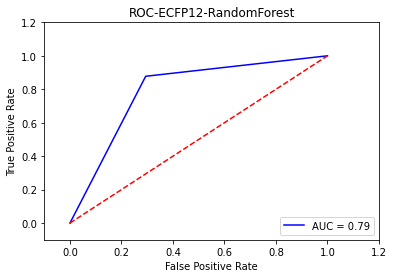

In [11]:
#Test-ECFP12
Train_accuracy_score = []
Test_accuracy_score = []

for i in range(times):
    X_train, X_test, y_train, y_test = model_selection.train_test_split(ECFP12, Active, test_size= Test_Size)

    rf = RandomForestClassifier(max_features='auto')
    rf.fit(X_train, y_train)

    rf_lab = rf.predict(X_train)
    rf_pre = rf.predict(X_test)
    
    Train_accuracy_score.append(accuracy_score(y_train,rf_lab))
    Test_accuracy_score.append(accuracy_score(y_test,rf_pre))

Mean_acc.append(statistics.mean(Test_accuracy_score))
print("Mean_Train_accuracy_score:",statistics.mean(Train_accuracy_score))
print("Mean_Test_accuracy_score:",statistics.mean(Test_accuracy_score))
print(classification_report(y_test, rf_pre, target_names=np.arange(2).astype(str)))

y_pred = rf.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.title('ROC-ECFP12-RandomForest')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.savefig("ROC.jpg", dpi = 300)
plt.show()

Mean_Train_accuracy_score: 1.0
Mean_Test_accuracy_score: 0.8529126213592233
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       157
           1       0.90      0.84      0.87       152

    accuracy                           0.87       309
   macro avg       0.88      0.87      0.87       309
weighted avg       0.88      0.87      0.87       309



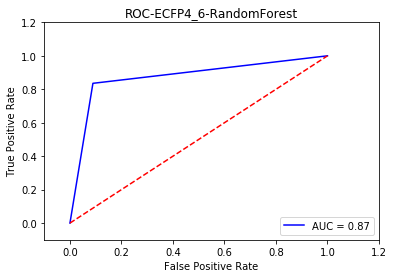

In [100]:
#Test-ECFP4_6
Train_accuracy_score = []
Test_accuracy_score = []

for i in range(times):
    X_train, X_test, y_train, y_test = model_selection.train_test_split(ECFP4_6, Active, test_size= Test_Size)

    rf = RandomForestClassifier(max_features='auto')
    rf.fit(X_train, y_train)

    rf_lab = rf.predict(X_train)
    rf_pre = rf.predict(X_test)
    
    Train_accuracy_score.append(accuracy_score(y_train,rf_lab))
    Test_accuracy_score.append(accuracy_score(y_test,rf_pre))

Mean_acc.append(statistics.mean(Test_accuracy_score))
print("Mean_Train_accuracy_score:",statistics.mean(Train_accuracy_score))
print("Mean_Test_accuracy_score:",statistics.mean(Test_accuracy_score))
print(classification_report(y_test, rf_pre, target_names=np.arange(2).astype(str)))

y_pred = rf.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.title('ROC-ECFP4_6-RandomForest')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.savefig("ROC.jpg", dpi = 300)
plt.show()

No handles with labels found to put in legend.


[1 1 0 0 1 1 1 1 0 1 0 1 1 1 1 0 0 1 0 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 0 1
 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 0 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 1 1 1 0 0 0 1 1 1 0 0 0 1 0 1 1 0 1 1 1 1 1 0 0 1 1 1 0
 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 0 1 1 1 1 0 1 1 1 0 1 0 1 1
 1 0 1 1 1 0 0 1 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 0 0 0 0 0 0 1 0]
[1, 1.0, 1.0, 0.6666666666666666, 0.5, 0.6, 0.6666666666666666, 0.7142857142857143, 0.75, 0.6666666666666666, 0.7, 0.6363636363636364, 0.6666666666666666, 0.6923076923076923, 0.7142857142857143, 0.7333333333333333, 0.6875, 0.6470588235294118, 0.6666666666666666, 0.631578947368421, 0.65, 0.6666666666666666, 0.6818181818181818, 0.6956521739130435, 0.7083333333333334, 0.72

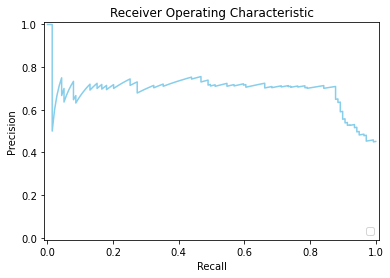

In [12]:
PR_curve(y_test, y_pred)

Mean_Train_accuracy_score: 1.0
Mean_Test_accuracy_score: 0.8606796116504855
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       140
           1       0.89      0.87      0.88       169

    accuracy                           0.87       309
   macro avg       0.87      0.87      0.87       309
weighted avg       0.87      0.87      0.87       309



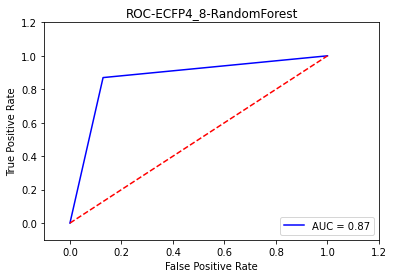

In [15]:
#Test-ECFP4_8
Train_accuracy_score = []
Test_accuracy_score = []

for i in range(times):
    X_train, X_test, y_train, y_test = model_selection.train_test_split(ECFP4_8, Active, test_size= Test_Size)

    rf = RandomForestClassifier(max_features='auto')
    rf.fit(X_train, y_train)

    rf_lab = rf.predict(X_train)
    rf_pre = rf.predict(X_test)
    
    Train_accuracy_score.append(accuracy_score(y_train,rf_lab))
    Test_accuracy_score.append(accuracy_score(y_test,rf_pre))

Mean_acc.append(statistics.mean(Test_accuracy_score))
print("Mean_Train_accuracy_score:",statistics.mean(Train_accuracy_score))
print("Mean_Test_accuracy_score:",statistics.mean(Test_accuracy_score))
print(classification_report(y_test, rf_pre, target_names=np.arange(2).astype(str)))

y_pred = rf.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.title('ROC-ECFP4_8-RandomForest')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.savefig("ROC.jpg", dpi = 300)
plt.show()

No handles with labels found to put in legend.


[1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0
 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 0 0 0 1 1 0 0 0 0
 0 0 1 0 0 0 0 1 0 0 0 0 0]
[1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9166666666666666, 0.9230769230769231, 0.9285714285714286, 0.9333333333333333, 0.9375, 0.9411764705882353, 0.9444444444444444, 0.8947368421052632, 0.9, 0.9047619047619048, 0.9090909090909091, 0.9130434782608695, 0.9166666666666666, 0.92, 0.9230769230769231, 0.9259259259259259, 0.9285714285714286, 0.931034482758

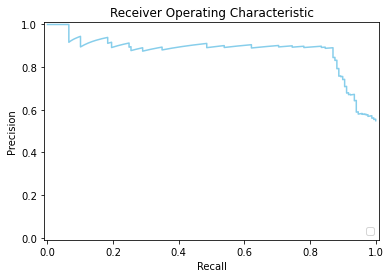

In [16]:
PR_curve(y_test, y_pred)

Mean_Train_accuracy_score: 1.0
Mean_Test_accuracy_score: 0.8462783171521036
              precision    recall  f1-score   support

           0       0.82      0.85      0.83       151
           1       0.85      0.82      0.83       158

    accuracy                           0.83       309
   macro avg       0.84      0.84      0.83       309
weighted avg       0.84      0.83      0.83       309



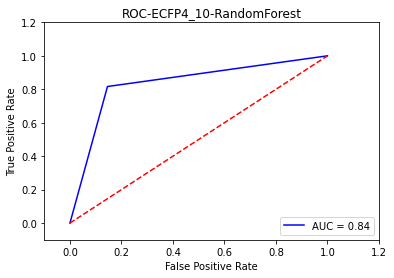

In [17]:
#Test-ECFP4_10
Train_accuracy_score = []
Test_accuracy_score = []

for i in range(times):
    X_train, X_test, y_train, y_test = model_selection.train_test_split(ECFP4_10, Active, test_size= Test_Size)

    rf = RandomForestClassifier(max_features='auto')
    rf.fit(X_train, y_train)

    rf_lab = rf.predict(X_train)
    rf_pre = rf.predict(X_test)
    
    Train_accuracy_score.append(accuracy_score(y_train,rf_lab))
    Test_accuracy_score.append(accuracy_score(y_test,rf_pre))

Mean_acc.append(statistics.mean(Test_accuracy_score))
print("Mean_Train_accuracy_score:",statistics.mean(Train_accuracy_score))
print("Mean_Test_accuracy_score:",statistics.mean(Test_accuracy_score))
print(classification_report(y_test, rf_pre, target_names=np.arange(2).astype(str)))

y_pred = rf.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.title('ROC-ECFP4_10-RandomForest')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.savefig("ROC.jpg", dpi = 300)
plt.show()

No handles with labels found to put in legend.


[1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0
 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 0 1 0 1 1 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 1 0 0]
[1, 1.0, 0.5, 0.6666666666666666, 0.75, 0.8, 0.8333333333333334, 0.8571428571428571, 0.875, 0.8888888888888888, 0.9, 0.9090909090909091, 0.8333333333333334, 0.8461538461538461, 0.7857142857142857, 0.8, 0.8125, 0.8235294117647058, 0.8333333333333334, 0.8421052631578947, 0.85, 0.8571428571428571, 0.8636363636363636, 0.8695652173913043, 0.8333333333333334, 0.84, 0.84615384

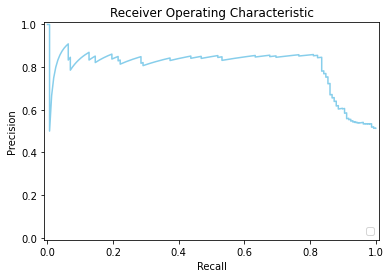

In [18]:
PR_curve(y_test, y_pred)

Mean_Train_accuracy_score: 1.0
Mean_Test_accuracy_score: 0.860032362459547
              precision    recall  f1-score   support

           0       0.84      0.87      0.86       149
           1       0.88      0.85      0.86       160

    accuracy                           0.86       309
   macro avg       0.86      0.86      0.86       309
weighted avg       0.86      0.86      0.86       309



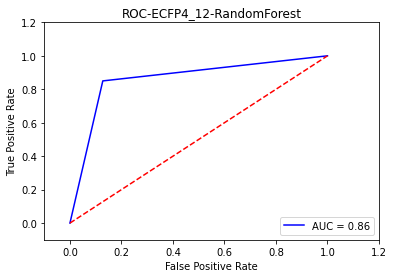

In [19]:
#Test-ECFP4_12
Train_accuracy_score = []
Test_accuracy_score = []

for i in range(times):
    X_train, X_test, y_train, y_test = model_selection.train_test_split(ECFP4_12, Active, test_size= Test_Size)

    rf = RandomForestClassifier(max_features='auto')
    rf.fit(X_train, y_train)

    rf_lab = rf.predict(X_train)
    rf_pre = rf.predict(X_test)
    
    Train_accuracy_score.append(accuracy_score(y_train,rf_lab))
    Test_accuracy_score.append(accuracy_score(y_test,rf_pre))

Mean_acc.append(statistics.mean(Test_accuracy_score))
print("Mean_Train_accuracy_score:",statistics.mean(Train_accuracy_score))
print("Mean_Test_accuracy_score:",statistics.mean(Test_accuracy_score))
print(classification_report(y_test, rf_pre, target_names=np.arange(2).astype(str)))

y_pred = rf.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.title('ROC-ECFP4_12-RandomForest')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.savefig("ROC.jpg", dpi = 300)
plt.show()

No handles with labels found to put in legend.


[1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1
 1 0 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1
 0 0 0 0 1 0 0 0 0 0 0 1 1]
[1, 1.0, 1.0, 0.6666666666666666, 0.75, 0.8, 0.8333333333333334, 0.8571428571428571, 0.875, 0.8888888888888888, 0.9, 0.8181818181818182, 0.8333333333333334, 0.8461538461538461, 0.8571428571428571, 0.8666666666666667, 0.875, 0.8823529411764706, 0.8333333333333334, 0.8421052631578947, 0.85, 0.8571428571428571, 0.8636363636363636, 0.8695652173913043, 0.875, 0.88, 0.8846153

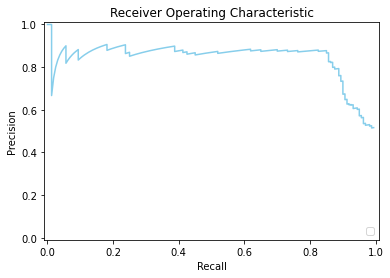

In [20]:
PR_curve(y_test, y_pred)

Mean_Train_accuracy_score: 1.0
Mean_Test_accuracy_score: 0.8420711974110032
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       149
           1       0.90      0.81      0.85       160

    accuracy                           0.85       309
   macro avg       0.86      0.86      0.85       309
weighted avg       0.86      0.85      0.85       309



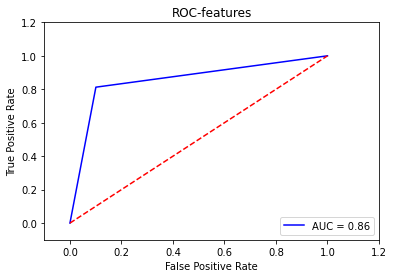

In [21]:
#Test-features
Train_accuracy_score = []
Test_accuracy_score = []

for i in range(times):
    #X_train, X_test, y_train, y_test = model_selection.train_test_split(features, False_Active, test_size= Test_Size)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(features, Active, test_size= Test_Size)
    rf = RandomForestClassifier(max_features='auto')
    rf.fit(X_train, y_train)

    rf_lab = rf.predict(X_train)
    rf_pre = rf.predict(X_test)
    
    Train_accuracy_score.append(accuracy_score(y_train,rf_lab))
    Test_accuracy_score.append(accuracy_score(y_test,rf_pre))

Mean_acc.append(statistics.mean(Test_accuracy_score))
print("Mean_Train_accuracy_score:",statistics.mean(Train_accuracy_score))
print("Mean_Test_accuracy_score:",statistics.mean(Test_accuracy_score))
print(classification_report(y_test, rf_pre, target_names=np.arange(2).astype(str)))

y_pred = rf.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.title('ROC-features')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.savefig("ROC.jpg", dpi = 300)
plt.show()

 1) Descriptors.MinEStateIndex     0.090376
 2) Descriptors.MaxAbsEStateIndex  0.075842
 3) Descriptors.MinAbsEStateIndex  0.039646
 4) Descriptors.qed                0.028590
 5) Descriptors.MolWt              0.017835
 6) Descriptors.HeavyAtomMolWt     0.017548
 7) Descriptors.ExactMolWt         0.017374
 8) Descriptors.NumValenceElectrons 0.016960
 9) Descriptors.NumRadicalElectrons 0.014748
10) Descriptors.MaxPartialCharge   0.014592
11) Descriptors.MinPartialCharge   0.013839
12) Descriptors.MaxAbsPartialCharge 0.012833
13) Descriptors.MinAbsPartialCharge 0.012705
14) Descriptors.FpDensityMorgan1   0.012453
15) Descriptors.FpDensityMorgan2   0.012358
16) Descriptors.FpDensityMorgan3   0.011253
17) Descriptors.BalabanJ           0.011087
18) Descriptors.BertzCT            0.010904
19) Descriptors.Chi0               0.010845
20) Descriptors.Chi0n              0.010670
21) Descriptors.Chi0v              0.010597
22) Descriptors.Chi1               0.010324
23) Descriptors.Chi1n       

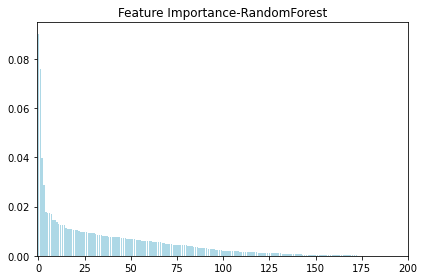

In [22]:
feat_labels = df.iloc[:,8:].columns[1:]
importances=rf.feature_importances_
indices=np.argsort(importances)[::-1]
for f in range(X_train.shape[1]-1):
    print ("%2d) %-*s %f" % (f+1,30,feat_labels[f],importances[indices[f]]))
    #print ("%2d) %-*s %f" % (f+1,30,feat_labels[[indices[f]]],importances[indices[f]])) 
plt.title('Feature Importance-RandomForest')
plt.bar(range(X_train.shape[1]),importances[indices],color='lightblue',align='center')
#plt.xticks(range(X_train.shape[1]),feat_labels,rotation=90)
plt.xlim([-1,X_train.shape[1]])
plt.tight_layout()
plt.show()

No handles with labels found to put in legend.


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0
 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 1 0 1 0 1 0 0
 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 1 1 1 0 0 0 1 0 0 0 1
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1 0 1 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0]
[1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9473684210526315, 0.95, 0.9523809523809523, 0.9545454545454546, 0.9565217391304348, 0.9583333333333334, 0.96, 0.9615384615384616, 0.9629629629629629, 0.9642857142857143, 0.9310344827586207, 0.9333333333333333, 0.9354838709677419, 0.9375, 0.9393939393939394, 0.9411764705882353

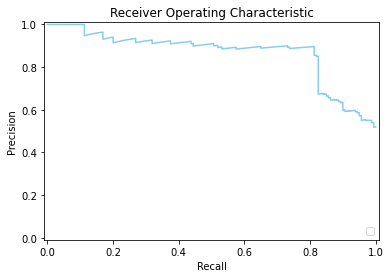

In [23]:
PR_curve(y_test, y_pred)

Mean_Train_accuracy_score: 1.0
Mean_Test_accuracy_score: 0.8669902912621359
              precision    recall  f1-score   support

           0       0.85      0.92      0.89       157
           1       0.91      0.84      0.87       152

    accuracy                           0.88       309
   macro avg       0.88      0.88      0.88       309
weighted avg       0.88      0.88      0.88       309



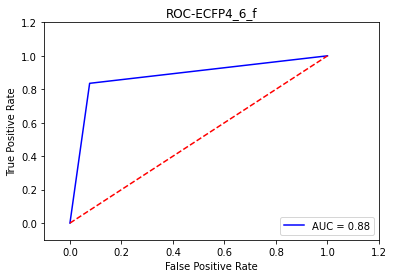

In [25]:
#Test-pca_ECFP4_6_f
Train_accuracy_score = []
Test_accuracy_score = []

for i in range(times):
    X_train, X_test, y_train, y_test = model_selection.train_test_split(ECFP4_6_f, Active, test_size= Test_Size)

    rf = RandomForestClassifier(max_features='auto')
    rf.fit(X_train, y_train)

    rf_lab = rf.predict(X_train)
    rf_pre = rf.predict(X_test)
    
    Train_accuracy_score.append(accuracy_score(y_train,rf_lab))
    Test_accuracy_score.append(accuracy_score(y_test,rf_pre))

Mean_acc.append(statistics.mean(Test_accuracy_score))
print("Mean_Train_accuracy_score:",statistics.mean(Train_accuracy_score))
print("Mean_Test_accuracy_score:",statistics.mean(Test_accuracy_score))
print(classification_report(y_test, rf_pre, target_names=np.arange(2).astype(str)))

y_pred = rf.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.title('ROC-ECFP4_6_f')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.savefig("ROC.jpg", dpi = 300)
plt.show()

No handles with labels found to put in legend.


[1 1 1 0 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0
 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 1
 1 0 1 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 0 1 0 1 0 0 0 0]
[1, 1.0, 1.0, 1.0, 0.75, 0.6, 0.6666666666666666, 0.7142857142857143, 0.625, 0.6666666666666666, 0.7, 0.7272727272727273, 0.75, 0.7692307692307693, 0.7857142857142857, 0.7333333333333333, 0.75, 0.7647058823529411, 0.7777777777777778, 0.7894736842105263, 0.8, 0.8095238095238095, 0.7727272727272727, 0.782608695652174, 0.7916666666666666, 0.8, 0.8076923076923077, 0.8148148

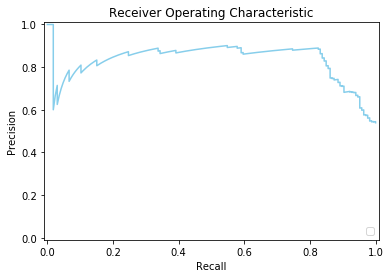

In [109]:
PR_curve(y_test, y_pred)

In [26]:
estimator = PCA(n_components = 20)
pca_features = estimator.fit_transform(features)
#pca_features = pd.DataFrame(pca_features, columns = [i for i in range(20)])
pca_features

array([[-2.61074735e+26, -4.49444327e+11,  8.92470823e+11, ...,
         4.32263107e+09,  4.39451758e+10,  3.28389884e+09],
       [-2.61074735e+26, -3.15393502e+11,  2.73257262e+11, ...,
         3.88470392e+11,  6.27069606e+11,  2.05393736e+11],
       [-2.61074735e+26,  6.93538481e+11, -3.83599480e+11, ...,
         5.54568886e+11,  2.66806609e+11,  2.18091904e+10],
       ...,
       [-2.61074735e+26,  2.61646264e+11, -1.98361067e+11, ...,
        -1.14996890e+12, -1.07604500e+12,  1.80911614e+11],
       [-2.61074735e+26,  7.02783052e+11, -4.47281377e+10, ...,
         1.16890231e+11, -1.74229190e+12, -1.66398850e+11],
       [-2.61074735e+26, -7.24344461e+11, -5.68654271e+11, ...,
        -2.12817772e+11, -7.21233925e+11,  5.93086156e+11]])

Mean_Train_accuracy_score: 1.0
Mean_Test_accuracy_score: 0.7758899676375405
              precision    recall  f1-score   support

           0       0.77      0.75      0.76       158
           1       0.74      0.76      0.75       151

    accuracy                           0.75       309
   macro avg       0.75      0.75      0.75       309
weighted avg       0.75      0.75      0.75       309



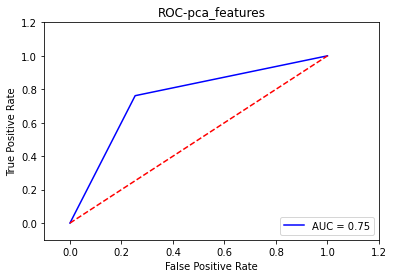

In [27]:
#Test-pca_features
Train_accuracy_score = []
Test_accuracy_score = []

for i in range(times):
    X_train, X_test, y_train, y_test = model_selection.train_test_split(pca_features, Active, test_size= Test_Size)

    rf = RandomForestClassifier(max_features='auto')
    rf.fit(X_train, y_train)

    rf_lab = rf.predict(X_train)
    rf_pre = rf.predict(X_test)
    
    Train_accuracy_score.append(accuracy_score(y_train,rf_lab))
    Test_accuracy_score.append(accuracy_score(y_test,rf_pre))

Mean_acc.append(statistics.mean(Test_accuracy_score))
print("Mean_Train_accuracy_score:",statistics.mean(Train_accuracy_score))
print("Mean_Test_accuracy_score:",statistics.mean(Test_accuracy_score))
print(classification_report(y_test, rf_pre, target_names=np.arange(2).astype(str)))

y_pred = rf.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.title('ROC-pca_features')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.savefig("ROC.jpg", dpi = 300)
plt.show()

No handles with labels found to put in legend.


[1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 0 0 1 1
 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 0 0 0 0 1 0 1 1 0 1 1 1 1 1 0 1
 0 0 1 0 1 1 1 0 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 0 0 0 1 1 1 1 1 1 0 1 1 1
 0 0 1 1 1 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1
 1 0 0 1 1 1 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1
 1 1 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 1 1 0 0 1 0 0 1 0 0 0 0
 0 1 0 0 0 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 1 1 0 0]
[1, 1.0, 1.0, 0.6666666666666666, 0.75, 0.8, 0.8333333333333334, 0.8571428571428571, 0.875, 0.7777777777777778, 0.8, 0.8181818181818182, 0.8333333333333334, 0.7692307692307693, 0.7857142857142857, 0.8, 0.8125, 0.8235294117647058, 0.8333333333333334, 0.8421052631578947, 0.85, 0.8095238095238095, 0.8181818181818182, 0.782608695652174, 0.7916666666666666, 0.76, 0.769230769

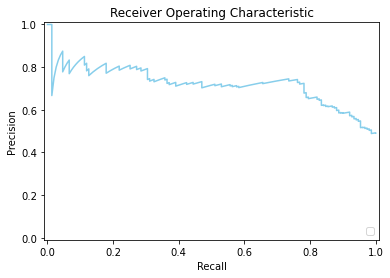

In [28]:
PR_curve(y_test, y_pred)

 1) 0                              0.105873
 2) 1                              0.090627
 3) 2                              0.086725
 4) 3                              0.060193
 5) 4                              0.056628
 6) 5                              0.056160
 7) 6                              0.054538
 8) 7                              0.048957
 9) 8                              0.048134
10) 9                              0.047506
11) 10                             0.042104
12) 11                             0.040372
13) 12                             0.039776
14) 13                             0.039111
15) 14                             0.038838
16) 15                             0.038373
17) 16                             0.037003
18) 17                             0.034902
19) 18                             0.033547


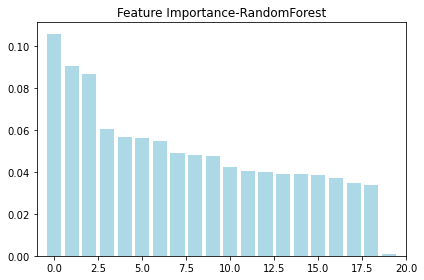

In [29]:
feat_labels = range(20)
importances=rf.feature_importances_
indices=np.argsort(importances)[::-1]
for f in range(X_train.shape[1]-1):
    print ("%2d) %-*s %f" % (f+1,30,feat_labels[f],importances[indices[f]]))
    #print ("%2d) %-*s %f" % (f+1,30,feat_labels[[indices[f]]],importances[indices[f]])) 
plt.title('Feature Importance-RandomForest')
plt.bar(range(X_train.shape[1]),importances[indices],color='lightblue',align='center')
#plt.xticks(range(X_train.shape[1]),feat_labels,rotation=90)
plt.xlim([-1,X_train.shape[1]])
plt.tight_layout()
plt.show()

Mean_Train_accuracy_score: 1.0
Mean_Test_accuracy_score: 0.8580906148867313
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       150
           1       0.89      0.83      0.86       159

    accuracy                           0.86       309
   macro avg       0.86      0.86      0.86       309
weighted avg       0.86      0.86      0.86       309



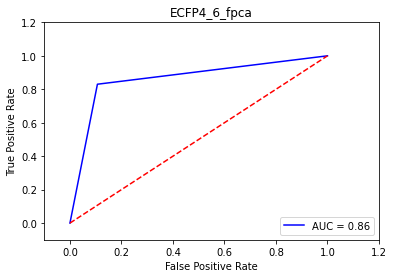

In [30]:
#Test-ECFP4_6_fpca
ECFP4_6_fpca = np.concatenate((ECFP4, ECFP6, pca_features), axis=1)

Train_accuracy_score = []
Test_accuracy_score = []

for i in range(times):
    X_train, X_test, y_train, y_test = model_selection.train_test_split(ECFP4_6_fpca, Active, test_size= Test_Size)

    rf = RandomForestClassifier(max_features='auto')
    rf.fit(X_train, y_train)

    rf_lab = rf.predict(X_train)
    rf_pre = rf.predict(X_test)
    
    Train_accuracy_score.append(accuracy_score(y_train,rf_lab))
    Test_accuracy_score.append(accuracy_score(y_test,rf_pre))

Mean_acc.append(statistics.mean(Test_accuracy_score))
print("Mean_Train_accuracy_score:",statistics.mean(Train_accuracy_score))
print("Mean_Test_accuracy_score:",statistics.mean(Test_accuracy_score))
print(classification_report(y_test, rf_pre, target_names=np.arange(2).astype(str)))

y_pred = rf.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.title('ECFP4_6_fpca')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.savefig("ROC.jpg", dpi = 300)
plt.show()

No handles with labels found to put in legend.


[1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1
 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 1 1 0 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 1]
[1, 1.0, 1.0, 0.6666666666666666, 0.75, 0.8, 0.8333333333333334, 0.7142857142857143, 0.75, 0.7777777777777778, 0.8, 0.8181818181818182, 0.8333333333333334, 0.8461538461538461, 0.7857142857142857, 0.8, 0.8125, 0.8235294117647058, 0.8333333333333334, 0.8421052631578947, 0.85, 0.8571428571428571, 0.8636363636363636, 0.8695652173913043, 0.875, 0.88, 0.8846153846153846, 0.88

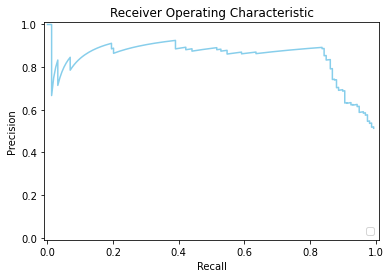

In [31]:
PR_curve(y_test, y_pred)

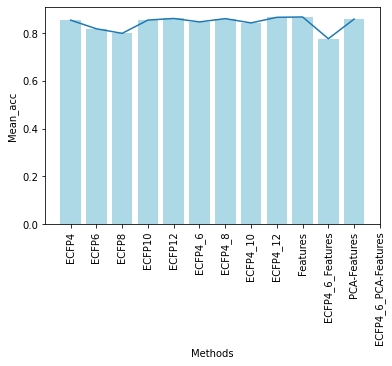

In [36]:
Methods = ['ECFP4','ECFP6','ECFP8','ECFP10','ECFP12','ECFP4_6','ECFP4_8','ECFP4_10','ECFP4_12','Features','ECFP4_6_Features','PCA-Features','ECFP4_6_PCA-Features']
plt.ylabel('Mean_acc')
plt.xlabel('Methods')
plt.plot(Mean_acc)
plt.bar(range(len(Mean_acc)),Mean_acc,color='lightblue',align='center')
plt.xticks(range(13),Methods,rotation=90)
plt.show()
#print(Mean_acc)